In [0]:
# Pronóstico adaptativo

## Descripción del problema real

Los pronósticos de los precios de la electricidad en mercados liberalizados son un insumo fundamental para la toma de decisiones dentro de las organizaciones. Fundamentalmente, los pronosticos de corto plazo son utilizados en decisiones de carácter operativo. En el caso abordado, es necesario contar con los pronósticos para definir la politica de operación de una empresa del sector eléctrico.

## Descripción del problema en términos de los datos

La carpeta `datos/precios/` contiene los precios historicos horarios de la electricidad en la Bolsa de Energía del mercado eléctrico colombiano, publicados por el operador del mercado. Se desean obtener pronósticos para el precio promedio diario para los próximos siete (7) días a la fecha actual.

## Aproximaciones posibles

En este caso, se desea evaluar la capacidad de pronóstico de un ADALINE con aprendizaje en línea.

## Requerimientos

Usted debe:

* Procesar los datos históricos para conformar el conjunto de datos. Los archivos de Excel no pueden ser modificados y actualizados directamente por el operador del sistema. Su código debe leer los archivos y crear la serie de precios promedio diarios de la electricidad.


* Determinar si el modelo debe pronosticar los precios promedios sin ninguna transformación, o si la inclusión de una transformación (logaritmo natural, raíz cúbica, raíz cuadrada, etc) resulta en un incremento de la precisión del pronóstico.


* Generar el pronóstico para los precios de los próximos siete días.


* Preparar el código para que el modelo sea entrenado usando el gradiente y el momentum.


* Determinar cuál es el número óptimo de retardos (observaciones) que el modelo debe considerar hacia atrás para producir el pronóstico.


* Determinar los valores óptimos de la tasa de aprendizaje y el momentum.


#Desarrollo del Entregable

#### Importación de componentes necesarios

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Carga de los datos

#### Para cargar desde el disco duro

In [0]:
from google.colab import files
uploaded = files.upload()

#### Para cargar archivos desde Drive, usaré esta opción en el desarrollo del Entregable

In [0]:
from google.colab import drive 
drive.mount('/content/gdrive')
carpeta_raiz = 'gdrive/My Drive/Colab Notebooks/evaluacion-cdramirezh-master/'

#ejemplo = pd.read_excel( carpeta_raiz + 'datos/precios/Precio_Bolsa_Nacional_($kwh)_1995.xlsx')

def driveToDataframes():

  nom_DB_prcs = [
                'Precio_Bolsa_Nacional_($kwh)_1995.xlsx',
                'Precio_Bolsa_Nacional_($kwh)_1996.xlsx',
                'Precio_Bolsa_Nacional_($kwh)_1997.xlsx',
                'Precio_Bolsa_Nacional_($kwh)_1998.xlsx',
                'Precio_Bolsa_Nacional_($kwh)_1999.xlsx',
                'Precio_Bolsa_Nacional_($kwh)_2000.xlsx',
                'Precio_Bolsa_Nacional_($kwh)_2001.xlsx',
                'Precio_Bolsa_Nacional_($kwh)_2002.xlsx',
                'Precio_Bolsa_Nacional_($kwh)_2003.xlsx',
                'Precio_Bolsa_Nacional_($kwh)_2004.xlsx',
                'Precio_Bolsa_Nacional_($kwh)_2005.xlsx',
                'Precio_Bolsa_Nacional_($kwh)_2006.xlsx',
                'Precio_Bolsa_Nacional_($kwh)_2007.xlsx',
                'Precio_Bolsa_Nacional_($kwh)_2008.xlsx',
                'Precio_Bolsa_Nacional_($kwh)_2009.xlsx',
                'Precio_Bolsa_Nacional_($kwh)_2010.xlsx',
                'Precio_Bolsa_Nacional_($kwh)_2011.xlsx',
                'Precio_Bolsa_Nacional_($kwh)_2012.xlsx',
                'Precio_Bolsa_Nacional_($kwh)_2013.xlsx',
                'Precio_Bolsa_Nacional_($kwh)_2014.xlsx',
                'Precio_Bolsa_Nacional_($kwh)_2015.xlsx',
                'Precio_Bolsa_Nacional_($kwh)_2016.xls',
                'Precio_Bolsa_Nacional_($kwh)_2017.xls',
                'Precio_Bolsa_Nacional_($kwh)_2018.xls'
              ]

  prcs = []

  for i in range(0,24):
    prcs.append ( pd.read_excel( carpeta_raiz + 'datos/precios/' + nom_DB_prcs[i] ) )
    
  return prcs

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


#### Para cargar archivos desde GitHub (aún no implementado)

### Convertir los archivos ya leidos en dataframes

In [0]:
prcs = driveToDataframes()

### Editar los Dataframes para facilitar su análisis

Vista de Dataframe para evidenciar algunas necesidades de modificación



In [0]:
prcs[16]

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,NaN
0,NaN,Precio Bolsa Nacional ($/kWh) 2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fecha,0,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,13.000000,14.000000,15.000000,16.000000,17.000000,18.000000,19.000000,20.000000,21.000000,22.000000,23.000000,Version,NaN
2,2011-01-01,88.1061,86.106093,65.106093,65.106093,52.106093,52.106093,52.106093,52.106093,52.106093,52.106093,52.106093,52.106093,65.106093,65.106093,52.106093,52.106093,52.106093,65.106093,96.106093,96.106093,96.106093,96.106093,86.106093,65.106093,TX4,67.022760
3,2011-01-02,36.2245,36.224485,36.223485,36.223485,36.223485,36.223485,34.838485,36.223485,36.224485,36.224485,63.560485,63.560485,79.560485,79.560485,63.560485,63.560485,63.560485,79.560485,94.560485,94.560485,94.560485,94.560485,83.560485,63.560485,TX4,60.112527
4,2011-01-03,58.1044,58.104362,58.104362,58.104362,58.104362,58.104362,58.104362,62.104362,88.104362,88.104362,93.104362,93.104362,93.104362,93.104362,93.104362,93.104362,93.104362,93.104362,118.104362,118.104362,118.104362,93.104362,88.104362,62.104362,TX4,82.812695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366,2011-12-31,39.6654,39.665407,39.664407,39.665407,39.664407,39.664407,39.665407,39.665407,39.665407,51.739407,51.739407,51.789407,51.789407,51.789407,51.739407,51.739407,51.739407,51.789407,82.289407,82.289407,82.289407,82.289407,78.789407,51.789407,TXF,53.440699
367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
368,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.013184
369,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Se puede observar que la primera y segunda fila no contienen registros de días, sino que contienen etiquetas; además, las últimas 4 filas están en NaN. En cuanto a las columnas, tienen nombres que no son útiles y las dos últimas corresponden a un datos que no interesa y a un promedio de costo diario del que se desconfía.




In [0]:
# Quitarles las primeras filas a los dataframes

prcs_ndr = [] #Precios sin las primeras filas ni dias repetidos

for i in range(0,5):
  prcs_ndr.append( prcs[i].drop([0,1,2]) )
for i in range(5,24):
  prcs_ndr.append( prcs[i].drop([0,1])  )

Eliminar días repetidos y NaNs de los Dataframes

In [0]:
# Quitarle los dias repetidos

prcs_ndr = prcs_ndr

prcs_ndr[1] = prcs_ndr[1][:366] #1996 tiene fechas repetidas al final
prcs_ndr[3] = prcs_ndr[3][:365] #1998 tiene fechas repetidas al final
prcs_ndr[4] = prcs_ndr[4][:365] #1998 tiene fechas repetidas al final
prcs_ndr[12] = prcs_ndr[12][:365] #2007 tiene fechas repetidas al final
prcs_ndr[14] = prcs_ndr[14][:365] #2009 tiene fechas repetidas al final
prcs_ndr[16] = prcs_ndr[16][:365] #2011 tiene NaN al final
prcs_ndr[17] = prcs_ndr[17][:366] #2012 tiene NaN al final
prcs_ndr[18] = prcs_ndr[18][:365] #2013 tiene NaN al final
prcs_ndr[19] = prcs_ndr[19][:365] #2014 tiene NaN al final

Eliminar columnas innecesarias o desconfiables

In [0]:
#Eliminar columnas innecesarias

prcs_ndr[5] = prcs_ndr[5].drop(labels="Unnamed: 25",axis=1)
prcs_ndr[10] = prcs_ndr[10].drop(labels="Unnamed: 25",axis=1)
prcs_ndr[15] = prcs_ndr[15].drop(labels="Unnamed: 25",axis=1)
prcs_ndr[16] = prcs_ndr[16].drop(labels="Unnamed: 25",axis=1)
prcs_ndr[16] = prcs_ndr[16].iloc[:, :-1] #Eliminar columna con NaN en 2011
prcs_ndr[17] = prcs_ndr[17].drop(labels="Unnamed: 25" ,axis=1)
prcs_ndr[17] = prcs_ndr[17].drop(labels="Unnamed: 26" ,axis=1)
prcs_ndr[18] = prcs_ndr[18].drop(labels="Unnamed: 25" ,axis=1)
prcs_ndr[18] = prcs_ndr[18].drop(labels="Unnamed: 26" ,axis=1)
prcs_ndr[19] = prcs_ndr[19].drop(labels="Unnamed: 25" ,axis=1)
prcs_ndr[19] = prcs_ndr[19].drop(labels="Unnamed: 26" ,axis=1)
prcs_ndr[20] = prcs_ndr[20].drop(labels="Unnamed: 25" ,axis=1)
prcs_ndr[21] = prcs_ndr[21].drop(labels="Unnamed: 25" ,axis=1)
prcs_ndr[22] = prcs_ndr[22].drop(labels="Unnamed: 25" ,axis=1)
prcs_ndr[23] = prcs_ndr[23].drop(labels="Unnamed: 25" ,axis=1)

Entre 2001 y 2009 (inclusive), la columna correspondiente a la fecha en cada dataframe, tiene nombre único. Se le pone el mismo nombre a todas las columnas para facilitar la manipulación del dataframe

In [0]:
#Estandarizar el nombre de la fecha para facilitar la union de los datos 
#(Entre 2001 y 2009 se usó un formato diferente)
prcs_lbl = [None]*24

for i in range(0,24):
  prcs_lbl[i] = prcs_ndr[i].copy(deep = True)
  prcs_lbl[i].columns = ['fecha',
                       'h0',
                       'h1',
                       'h2',
                       'h3',
                       'h4',
                       'h5',
                       'h6',
                       'h7',
                       'h8',
                       'h9',
                       'h10',
                       'h11',
                       'h12',
                       'h13',
                       'h14',
                       'h15',
                       'h16',
                       'h17',
                       'h18',
                       'h19',
                       'h20',
                       'h21',
                       'h22',
                       'h23']

In [0]:
prcs_lbl[16].head()

,fecha,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,h10,h11,h12,h13,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
2,2011-01-01,88.1061,86.106093,65.106093,65.106093,52.106093,52.106093,52.106093,52.106093,52.106093,52.106093,52.106093,52.106093,65.106093,65.106093,52.106093,52.106093,52.106093,65.106093,96.106093,96.106093,96.106093,96.106093,86.106093,65.106093
3,2011-01-02,36.2245,36.224485,36.223485,36.223485,36.223485,36.223485,34.838485,36.223485,36.224485,36.224485,63.560485,63.560485,79.560485,79.560485,63.560485,63.560485,63.560485,79.560485,94.560485,94.560485,94.560485,94.560485,83.560485,63.560485
4,2011-01-03,58.1044,58.104362,58.104362,58.104362,58.104362,58.104362,58.104362,62.104362,88.104362,88.104362,93.104362,93.104362,93.104362,93.104362,93.104362,93.104362,93.104362,93.104362,118.104362,118.104362,118.104362,93.104362,88.104362,62.104362
5,2011-01-04,49.7272,49.727173,49.727173,49.727173,49.727173,59.727173,76.727173,89.227173,89.227173,89.227173,94.727173,94.727173,94.727173,94.727173,94.727173,94.727173,94.727173,109.727173,109.727173,109.727173,109.727173,94.727173,89.227173,86.727173
6,2011-01-05,34.3371,34.337129,34.337129,34.337129,34.337129,38.344129,74.673129,83.673129,83.673129,83.673129,92.673129,92.673129,92.673129,92.673129,92.673129,92.673129,92.673129,92.673129,117.673129,127.673129,117.673129,92.673129,83.673129,83.673129


Unión de los Dataframes para alimentar el modelo predictivo con un solo archivo

In [0]:
#Unir Dataframes

prcs_con = pd.concat(prcs_lbl) #Dataframes de todos los años concatenados en uno solo

In [0]:
prcs_con

,fecha,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,h10,h11,h12,h13,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
3,1995-07-20,NaN,1.073000,1.073000,1.073000,1.073000,1.073000,1.073000,1.073000,1.074000,1.074000,2.827000,2.827000,2.827000,1.074000,1.073000,1.073000,1.073000,1.073000,1.074000,1.897000,1.897000,1.897000,1.073000,1.073000
4,1995-07-21,1.073,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,6.000000,6.000000,6.000000,6.000000,9.256000,9.256000,5.000000,5.000000,1.000000,1.000000,5.000000,12.000000,16.670000,11.929000,5.000000,1.000000,1.000000
5,1995-07-22,1.073,1.073000,1.000000,1.000000,1.000000,1.073000,1.303000,1.303000,1.303000,1.303000,1.303000,1.303000,1.303000,1.303000,1.073000,1.000000,1.000000,1.000000,1.303000,2.500000,2.500000,1.303000,1.073000,1.073000
6,1995-07-23,1.073,1.000000,1.000000,1.000000,1.000000,1.000000,0.100000,1.000000,1.000000,1.000000,1.000000,1.000000,1.238000,1.238000,1.000000,0.100000,0.100000,1.000000,1.238000,1.238000,1.238000,1.238000,1.073000,1.000000
7,1995-07-24,1,1.000000,0.990000,1.000000,1.000000,1.073000,3.000000,3.000000,3.000000,3.500000,8.845000,9.256000,3.000000,1.073000,1.073000,1.073000,3.000000,2.000000,18.630000,22.500000,9.256000,3.000000,1.073000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,2018-05-01,64.2292,64.229226,64.129226,64.129226,64.129226,64.129226,64.129226,64.229226,64.229226,69.229226,71.229226,81.229226,81.229226,71.229226,71.229226,71.229226,69.229226,81.229226,86.229226,86.229226,86.229226,81.229226,71.229226,64.229226
123,2018-05-02,63.3328,63.332816,63.332816,63.332816,63.332816,64.332816,67.832816,79.831816,80.832816,80.832816,80.832816,83.832816,83.832816,83.832816,83.832816,83.832816,80.832816,80.832816,83.832816,83.832816,83.832816,80.832816,80.832816,67.832816
124,2018-05-03,63.7108,64.210848,61.710848,61.710848,63.710848,64.210848,64.210848,67.710848,67.710848,67.710848,78.710848,79.710848,78.710848,78.710848,79.710848,79.710848,79.710848,67.710848,79.710848,79.710848,79.710848,67.710848,67.710848,63.710848
125,2018-05-04,61.5435,61.543453,61.543453,61.543453,61.543453,65.543453,61.543453,64.043453,65.543453,65.543453,65.543453,65.543453,65.543453,65.543453,65.543453,65.543453,65.543453,65.543453,65.543453,72.543453,65.543453,65.543453,65.543453,64.043453


Hacer el promedio por día del precio del kW/h

In [0]:
prcs_prom = prcs_con.copy(deep=True)
prcs_prom = prcs_prom.set_index('fecha')
prcs_prom = prcs_prom.mean( axis = 1 ).to_frame()
prcs_prom

,0
fecha,
1995-07-20,1.409435
1995-07-21,4.924333
1995-07-22,1.269500
1995-07-23,0.953083
1995-07-24,4.305917
...,...
2018-05-01,71.666726
2018-05-02,76.374441
2018-05-03,71.148348


Gráfica del comportamiento de los precios de la electricidad a lo largo de los últimos años. Se puede notar una tendencia a crecimiento lineal, por lo que se hará un ajuste con base en el IPC

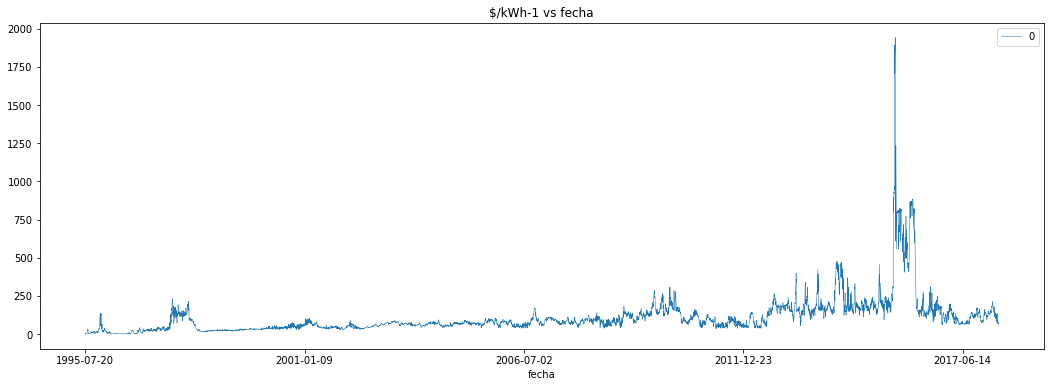

In [0]:
prcs_prom.plot(linewidth=0.5, title='$/kWh-1 vs fecha' , figsize=(18,6) )

# Ajuste de los datos al IPC

In [0]:
# Importar la DB de IPC
ipc = pd.read_excel( carpeta_raiz + 'datos/precios/' + '1.1.INF_Serie histórica Meta de inflación IQY.xlsx' )

In [0]:
# Quitar partes del dataframe del IPC que no necesito

ipc_ok = ipc.copy(deep = True)
ipc_ok.drop( labels=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 3', 'Unnamed: 4','Unnamed: 5'], axis = 1, inplace = True )
for i in range(0,28):
  ipc_ok.drop([i], inplace=True)

for i in range(309,341):
  ipc_ok.drop([i], inplace=True)
ipc_ok = ipc_ok.iloc[::-1]
ipc_ok

,Meta de inflación e inflación total al consumidor,Unnamed: 1
308,199501,21.04
307,199502,20.86
306,199503,21.33
305,199504,21.17
304,199505,21.3
...,...,...
32,201801,3.68
31,201802,3.37
30,201803,3.14
29,201804,3.13


In [0]:
ipc_list = ipc_ok.values.tolist()
prcs_prom_fechas = prcs_prom.reset_index()
prcs_list = prcs_prom_fechas.values.tolist()

#### Cálculo del factor normalizador para los precios

Puesto que en la base de datos recuperada del Banco de la república tiene una inflación mesual con respecto al mismo mes del año anterior, el ajuste propuesto es dividir los precios promedio del kW/h de cada día por la inflación acumulada del mes correspondiente en cada uno de los años anteriores hasta 1996. No se incluye 1995, pues este año será tomado como precio base. En la impresión de la siguiente celda se puede ver el factor de división normalizador del IPC de algunos meses y los periodos tenidos en cuenta para su cálculo

In [0]:
for i in range(0,281):
  
  divisor = ''
  divisor2 = 1
  j = i

  row_ipc = ipc_list[j]
  fecha_ipc = row_ipc[0]
  fecha_ipc=str(fecha_ipc) 
  year_ipc = fecha_ipc[0:4]
  mes_ipc = fecha_ipc[4:6]
  
  while ( j >= 12 ):
    
    row_ipc = ipc_list[j]
    fecha_ipc = row_ipc[0]
    fecha_ipc=str(fecha_ipc) 
    year_ipc = fecha_ipc[0:4]
    mes_ipc = fecha_ipc[4:6]

    divisor += year_ipc +' '+ mes_ipc + '*'
    divisor2 *= ( 1 + row_ipc[1]/100 )

    j = j - 12

  ipc_list[i].append(divisor2)
  if ( (i>8 and i < 12) or (i>277) ):
    print(ipc_list[i])
    print(divisor)
    print(divisor2)
    
    print('--------------------')


[199510, 20.52, 1]

1
--------------------
[199511, 20.13, 1]

1
--------------------
[199512, 19.46, 1]

1
--------------------
[201803, 3.14, 4.9851388952474105]
2018 03*2017 03*2016 03*2015 03*2014 03*2013 03*2012 03*2011 03*2010 03*2009 03*2008 03*2007 03*2006 03*2005 03*2004 03*2003 03*2002 03*2001 03*2000 03*1999 03*1998 03*1997 03*1996 03*
4.9851388952474105
--------------------
[201804, 3.13, 4.89924638510247]
2018 04*2017 04*2016 04*2015 04*2014 04*2013 04*2012 04*2011 04*2010 04*2009 04*2008 04*2007 04*2006 04*2005 04*2004 04*2003 04*2002 04*2001 04*2000 04*1999 04*1998 04*1997 04*1996 04*
4.89924638510247
--------------------
[201805, 3.16, 4.8308721271972646]
2018 05*2017 05*2016 05*2015 05*2014 05*2013 05*2012 05*2011 05*2010 05*2009 05*2008 05*2007 05*2006 05*2005 05*2004 05*2003 05*2002 05*2001 05*2000 05*1999 05*1998 05*1997 05*1996 05*
4.8308721271972646
--------------------


In [0]:
idx_ipc = 0
#Inicializacion con el primer periodo en los registros historicos de precio energia
year_ipc =  '1995' 
mes_ipc = '07'

for dia in range(0,8326):

  year_mes_prc = prcs_list[dia]
  fecha = year_mes_prc[0]

  #Sacar la fecha del registro de precio
  if ( type(fecha) is str ):
    mes = fecha[5:7]
  else:
    fecha = fecha.strftime('%Y %m')
    mes = fecha[5:7]
  year = fecha[0:4]
  
  if ( year == year_ipc and mes == mes_ipc ): #Si la fecha del precio a normalizar coincide con la fecha del ipc
    if ( int(year_ipc) >= 1996 ):
      #Dividir por el valor correspondiente en la lista de IPC normalizado
      prcs_list[dia][1] = prcs_list[dia][1] / ipc_list[idx_ipc][2]

  else: #Si la fecha no coincide con la fecha del IPC, pasar a la siguiente fecha del IPC
    idx_ipc += 1

    row_ipc = ipc_list[idx_ipc]
    fecha_ipc = row_ipc[0]
    fecha_ipc=str(fecha_ipc)

    year_ipc = fecha_ipc[0:4]
    mes_ipc = fecha_ipc[4:6]


# Aplicación de transformaciones propuestas

In [0]:
prcs_fin =[]
for i in range(0,len(prcs_list)):
  prcs_fin.append(prcs_list[i][1])

In [0]:
transformaciones = ['1','Ln','raiz2','raiz3']
transformadas = []

for t in transformaciones:
  temp = []
  for dia in prcs_fin:
    if t == '1':
      temp.append( dia )
    if t == 'Ln':
      temp.append( math.log(dia) )
    if t == 'raiz2':
      temp.append( math.sqrt(dia) )
    if t == 'raiz3':
      temp.append( dia ** (1.0/3.0) )
  transformadas.append(temp)

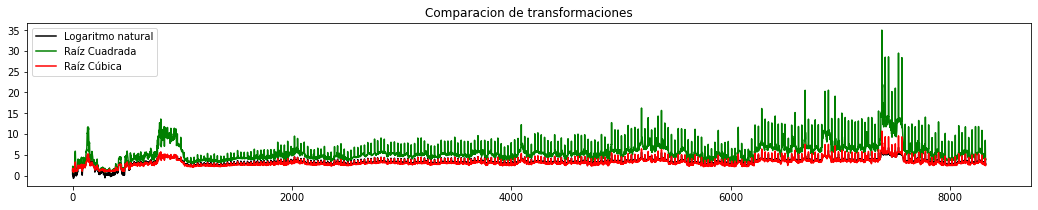

In [0]:
plt.figure(figsize=(18,3) )
plt.title('Comparacion de transformaciones')
plt.plot(transformadas[1], label="Logaritmo natural", color='black')
plt.plot(transformadas[2], label="Raíz Cuadrada", color='green')
plt.plot(transformadas[3], label="Raíz Cúbica", color='red')

plt.legend()
plt.show()

# Uso del Adaline visto en clase


In [0]:
class Adaline:
    def __init__(self,
                 learning_rate=0.001, # tasa de aprendizaje
                 max_epochs=100,      # número máximo de iteraciones sobre el set de datos
                 shuffle=False,       # mezcla patrones para aprendizaje online
                 random_state=None,   #
                 warm_start=False):   #

        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.shuffle = shuffle
        self.random_state = random_state
        self.warm_start = warm_start
        self.coef_ = None
        self.intercept_ = None

    def fit(self, X, y):

        if not isinstance(X, np.ndarray):
            X = np.array(X)
        if not isinstance(y, np.ndarray):
            d = np.array(y)
        else:
            d = y.copy()

        if self.random_state is not None:
            np.random.RandomState(self.random_state)

        if self.coef_ is None or self.warm_start is False:
            self.coef_ = np.random.uniform(-1, 1, X.shape[1])

        if self.intercept_ is None  or self.warm_start is False:
            self.intercept_ = np.random.uniform(-1, 1, 1)

        errors2 = []
        forecasts = []

        for epoch in range(self.max_epochs):

            if self.shuffle is True:
                n = list(range(X.shape[0]))
                np.random.shuffle(n)
                X = X[n,:]
                d = d[n]

            for i in range(X.shape[0]):
                u = np.dot(X[i,:], self.coef_) + self.intercept_
                e = (d[i] - u)[0]
                self.coef_ += 2 * self.learning_rate * e * X[i,:]
                self.intercept_ += 2 * self.learning_rate * e
                errors2.append(e**2)
                forecasts.append(u)

        return errors2, forecasts

    def predict(self, X):
        if not isinstance(X, np.ndarray):
            X = np.array(X)
        u = np.dot(X, self.coef_) + self.intercept_
        return u

# Aplicación del modelo para cada una de las transformaciones

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in add
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in add


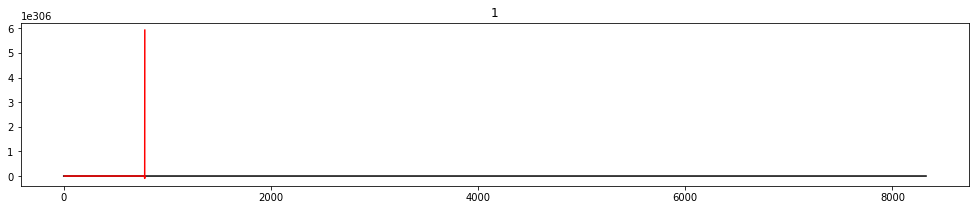

/usr/local/lib/python3.6/dist-packages/matplotlib/ticker.py:2192: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


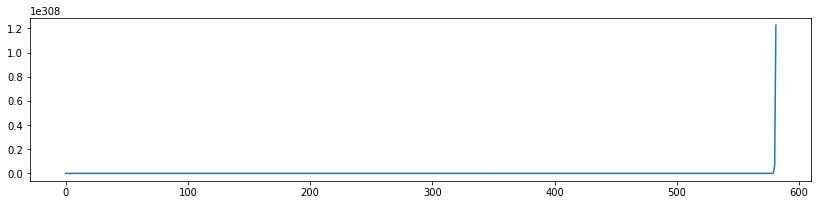

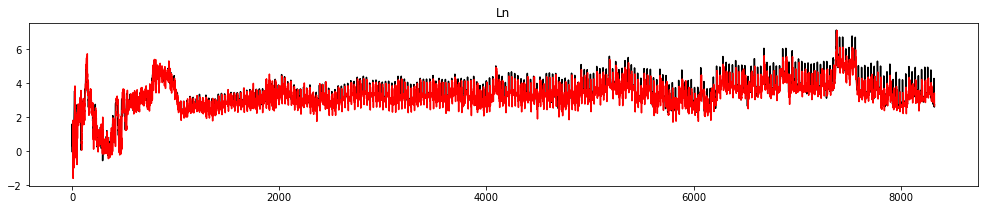

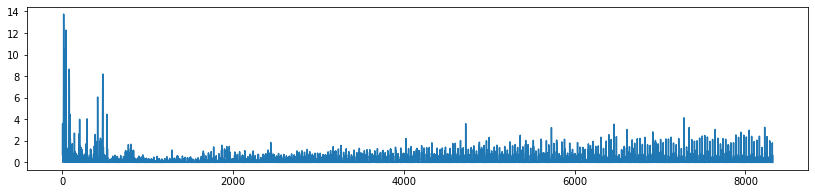

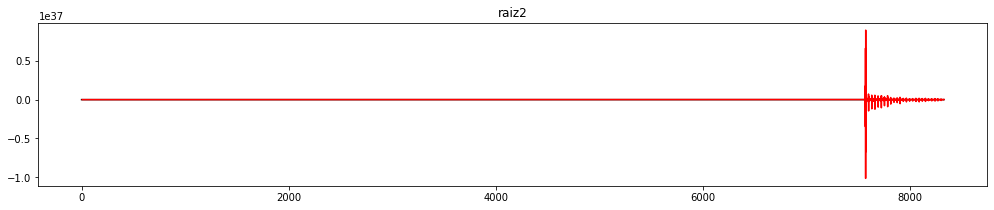

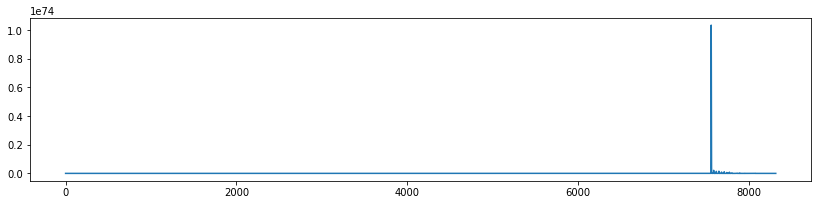

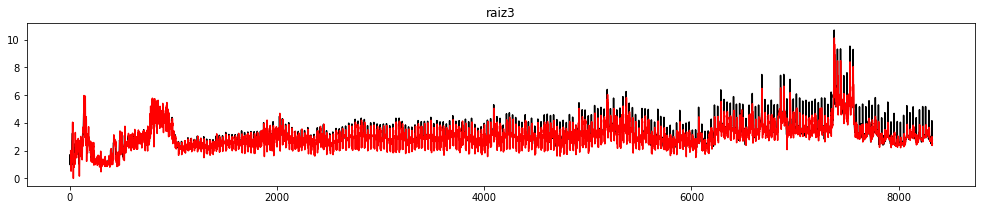

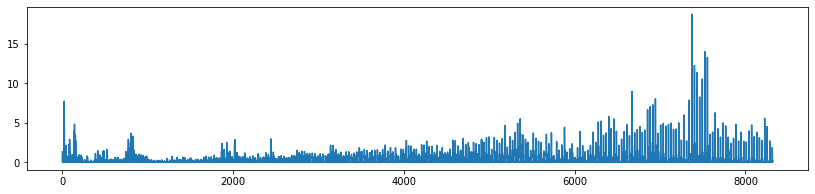

In [0]:
j = 0
for indice in transformadas:
  
  L = 7
  X = []
  for t in range(L, len(prcs_fin)):
   
    X.append(indice[t-L:t].copy())

  adaline = Adaline(
    learning_rate=0.001,  # tasa de aprendizaje
    max_epochs=1,        # número máximo de iteraciones sobre el set de datos
    shuffle=False,       # mezcla patrones para aprendizaje online
    random_state=123,    # corrida reproducible
    warm_start=False)    # inicia con pesos aleatorios

  errors2, forecasts = adaline.fit(
    X,
    indice[L:])
  
  plt.figure(figsize=(17,3))
  plt.title(transformaciones[j])
  j +=1
  plt.plot(indice, color='black');
  plt.plot(range(L,len(indice)), forecasts, color = 'red');

  plt.figure(figsize=(14,3))
  plt.plot(errors2);

**Análisis de los modelos**

Se puede ver que la transformación no solo mejora la predicción del modelo, sino que es necesario hacer una transformación para que se pueda construir un modelo decente. Se elije la transformación de Logaritmo natural, puedo que la evolución del error de esta se mantiene consistente, mientras que el error de la transformación de raíz cúbica, tienen un error que aumenta del estado aceptable después de haberlo alcanzado


# Pronóstico para próximos 7 días

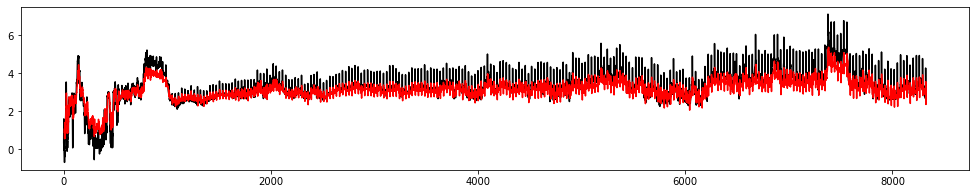

In [0]:
hay = adaline.predict(X)
plt.figure(figsize=(17,3))
plt.plot(transformadas[1], color='black');
plt.plot(range(L,len(transformadas[1])), hay , color = 'red');

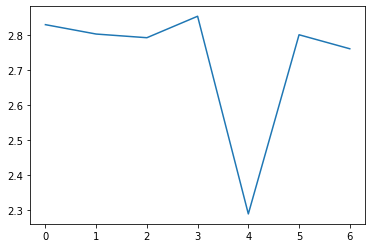

In [259]:
pronostico = hay[-7:]
for p in pronostico:
  p = math.e ** p
plt.plot(pronostico)